<h1><strong>Warehouse Reallocation Strategy for Multi-City Logistics</strong></h1>
<hr>
<h2><strong>Introduction</strong></h2>
<p>In a multi-city supply chain, delivery delays can hurt customer satisfaction and increase costs — especially if warehouses are poorly located. The aim of this project is to dig into real-world shipment data, figure out where delays are happening, and suggest better warehouse placements that could improve overall delivery performance.

Think of it like this:

<strong>If we’re consistently late delivering to some countries, could shifting warehouse locations help?</strong>

We’ll break this problem down with data, back it up with visuals, and even simulate a possible reallocation scenario to show how much better things could be.</p>
<hr>
<h2><strong>About the Dataset</strong></h2>
<p>The data comes from the Supply Chain Management System (SCMS) and includes over 10,000 shipment records. Each row tracks a delivery — from where it was manufactured to where it was delivered — along with dates, quantities, freight costs, and more.

Key things we’ll use:
<ul>
<li>Country: where the shipment was delivered</li>

<li>Manufacturing Site: acts like the “warehouse” in this case</li>

<li>Scheduled vs Delivered Dates: lets us measure delays</li>

<li>Quantity & Freight Cost: helps us see where high volumes or high costs are involved</li>
</ul>

This gives us plenty of room to spot inefficiencies and patterns.</p>
<hr>
<h2><strong>What We’ll Explore</strong></h2>
<p>To make sense of this dataset and turn it into something useful, we’ll focus on 5 core questions. These aren’t just for the sake of analysis — each one plays a role in helping us figure out whether relocating a warehouse would actually reduce delays.</p>

<ol>
  <li><strong>Which countries are experiencing the longest average delivery delays <em>and</em> the highest shipment volumes?</strong><br>
  → This helps us focus on high-impact regions, not just isolated delays.</li>

  <li><strong>Which manufacturing sites (our warehouse equivalents) are responsible for those delays?</strong><br>
  → We need to find out if specific warehouses are consistently underperforming.</li>

  <li><strong>Which countries are far from current warehouses and suffering from high delays?</strong><br>
  → This helps identify regions that are likely underserved and may benefit from a closer warehouse.</li>

  <li><strong>What would happen if we reassigned deliveries from a poorly performing warehouse to a better one?</strong><br>
  → This is the test — to see if a simple change could reduce delays.</li>

  <li><strong>Based on everything above, what would be a better warehouse location to serve high-delay regions more efficiently?</strong><br>
  → This is our final recommendation — the decision a logistics manager actually cares about.</li>
</ol>

<hr>

<h2><strong>Why These Questions Are Enough</strong></h2>
<p>These 5 questions are designed to fully cover the business problem — without drifting into unnecessary analysis.</p>

<ul>
  <li>They start by identifying where the biggest problems are.</li>
  <li>They trace those problems back to their source.</li>
  <li>They reveal operational gaps — places that are poorly served.</li>
  <li>They include a real-world simulation to prove a better setup is possible.</li>
  <li>And they lead to a clear, data-backed recommendation.</li>
</ul>

<p>With just these 5, the project tells a complete story — from problem to diagnosis to solution.</p>
<hr>

In [24]:
# Loading the dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('Dataset.csv',encoding='ISO-8859-1')
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [25]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

<h4>Calculating Delivery Delay</h4>

In [26]:
# Convert date columns to datetime format
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'], errors='coerce')
df['Delivered to Client Date'] = pd.to_datetime(df['Delivered to Client Date'], errors='coerce')

# Calculate delivery delay in days
df['Delivery_Delay_Days'] = (df['Delivered to Client Date'] - df['Scheduled Delivery Date']).dt.days

df[['Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery_Delay_Days']].head()


<ipython-input-26-47180713b476>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'], errors='coerce')
<ipython-input-26-47180713b476>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Delivered to Client Date'] = pd.to_datetime(df['Delivered to Client Date'], errors='coerce')


,Scheduled Delivery Date,Delivered to Client Date,Delivery_Delay_Days
0,2006-06-02,2006-06-02,0
1,2006-11-14,2006-11-14,0
2,2006-08-27,2006-08-27,0
3,2006-09-01,2006-09-01,0
4,2006-08-11,2006-08-11,0


In [27]:
df.describe()

,ID,Scheduled Delivery Date,Delivered to Client Date,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD),Delivery_Delay_Days
count,10324.000000,10324,10324,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000,10324.000000
mean,51098.968229,2011-10-04 15:30:28.593568512,2011-09-28 14:56:34.963192576,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626,-6.023537
min,1.000000,2006-05-02 00:00:00,2006-05-02 00:00:00,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,-372.000000
25%,12795.750000,2009-09-08 00:00:00,2009-09-01 00:00:00,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000,-3.000000
50%,57540.500000,2011-12-05 00:00:00,2011-11-25 00:00:00,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000,0.000000
75%,83648.250000,2013-12-23 00:00:00,2013-12-23 00:00:00,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000,0.000000
max,86823.000000,2015-12-31 00:00:00,2015-09-14 00:00:00,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000,192.000000
std,31944.332496,NaN,NaN,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568,27.233640


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ID                            10324 non-null  int64         
 1   Project Code                  10324 non-null  object        
 2   PQ #                          10324 non-null  object        
 3   PO / SO #                     10324 non-null  object        
 4   ASN/DN #                      10324 non-null  object        
 5   Country                       10324 non-null  object        
 6   Managed By                    10324 non-null  object        
 7   Fulfill Via                   10324 non-null  object        
 8   Vendor INCO Term              10324 non-null  object        
 9   Shipment Mode                 9964 non-null   object        
 10  PQ First Sent to Client Date  10324 non-null  object        
 11  PO Sent to Vendor Date      

In [29]:
df.isnull().sum()

,0
ID,0
Project Code,0
PQ #,0
PO / SO #,0
ASN/DN #,0
Country,0
Managed By,0
Fulfill Via,0
Vendor INCO Term,0
Shipment Mode,360


<h4><strong>Correlation Between Numeric Variables</strong></h4>
<p>Before we dive into deeper analysis, it’s smart to check whether any numeric columns are heavily correlated. For example, if freight cost and quantity move together, we don’t want to double count their effect. Here’s a quick heatmap to reveal those relationships.</p>


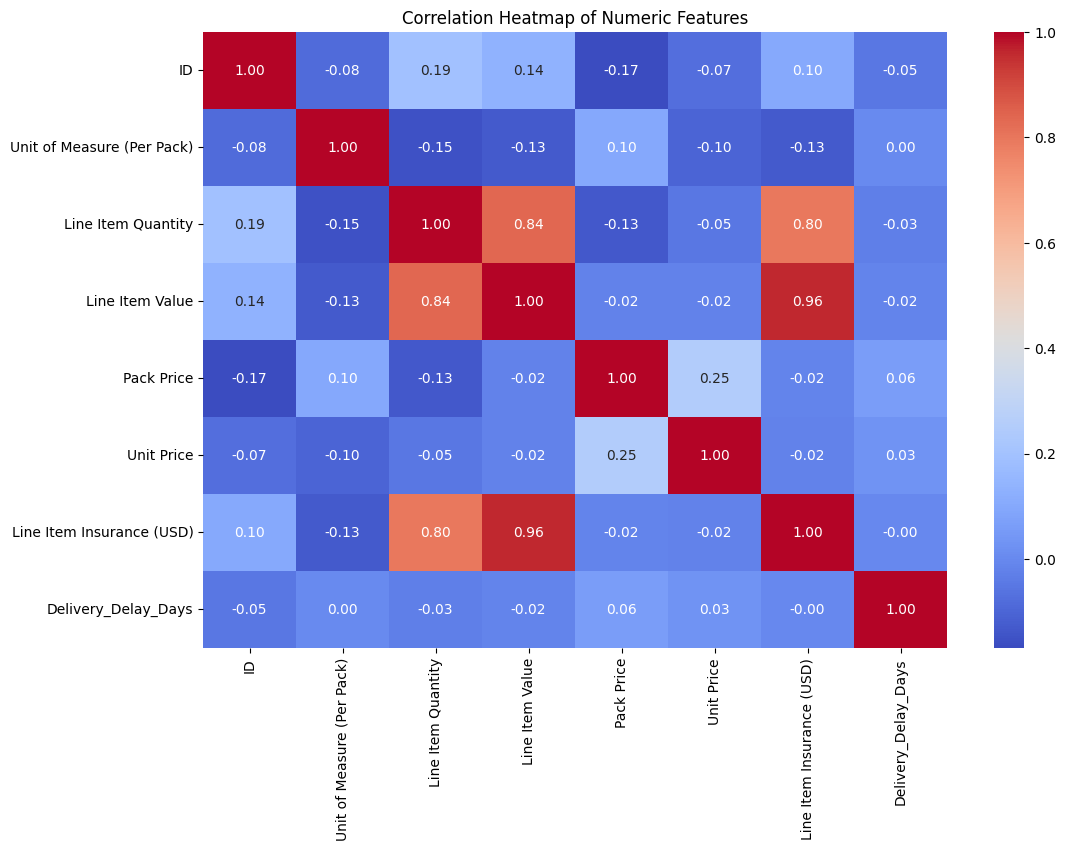

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


<h4><strong>Correlation Check: What’s Actually Related to What?</strong></h4>
<p>
Before we get lost in the weeds, this heatmap gives a quick reality check: which columns move together — and which ones don’t.
</p>

<ul>
  <li><strong>Line Item Quantity & Line Item Value:</strong> No surprise here — bigger orders = higher value. They’re strongly linked.</li>
  <li><strong>Line Item Value & Insurance:</strong> Basically twins. More value means more insurance.</li>
  <li><strong>Pack Price & Unit Price:</strong> They’re kind of floating on their own. Not strongly tied to much.</li>
  <li><strong>Delivery Delay:</strong> This one’s interesting — it doesn’t really correlate with any numeric field. That’s actually a good thing. It tells us that delays aren’t just about quantity or cost. There’s something else behind them — maybe vendor performance, country distance, etc.</li>
</ul>

<p>
<strong>Bottom line:</strong><br>
We now know what’s redundant (Value & Insurance), and what’s worth looking into deeper (Delivery Delay stands alone). No need to include both value and insurance in every analysis — they tell the same story.
</p>


<h4><strong>Delivery Delay Spread by Country</strong></h4>
<p>Some countries might have a few extreme delays pulling the average up. To really see how consistent or chaotic each country is, a boxplot shows us the full spread — including outliers. This helps spot unstable regions that might need closer warehouses or alternate vendors.</p>


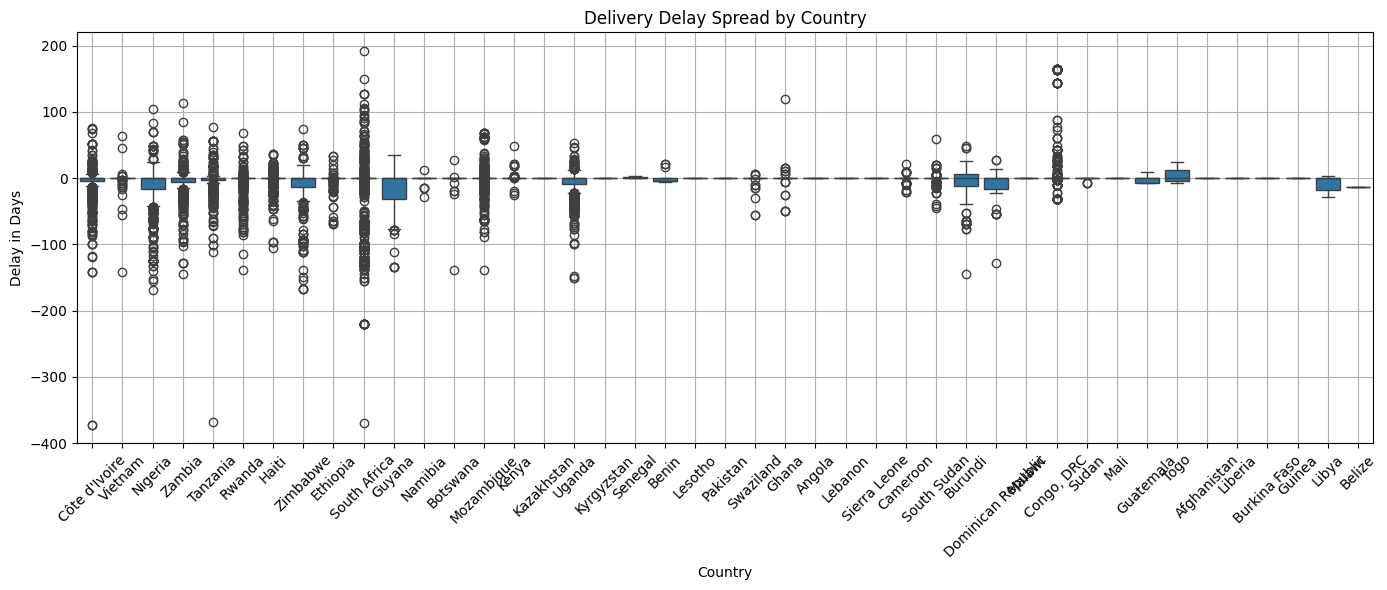

In [31]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Country', y='Delivery_Delay_Days', data=df)
plt.xticks(rotation=45)
plt.title('Delivery Delay Spread by Country')
plt.ylabel('Delay in Days')
plt.xlabel('Country')
plt.grid(True)
plt.tight_layout()
plt.show()


<h4><strong>Delivery Delay Spread by Country</strong></h4>
<p>
This boxplot shows us how chaotic the delivery timelines are in each country.
The <strong>wider and taller the box</strong>, the more inconsistent the delays. A country with a compact box around zero means delivery times are predictable. But the ones with <strong>huge whiskers and tons of outliers</strong>? Those are a logistics nightmare.
</p>

<ul>
  <li><strong>Côte d’Ivoire, Zimbabwe, Zambia</strong> – Wild spread. Delays range from early to extremely late deliveries. These need deeper investigation.</li>
  <li><strong>Vietnam & Nigeria</strong> – More consistent but still with frequent delays beyond acceptable limits.</li>
  <li><strong>Uganda, Mozambique, Haiti</strong> – Pretty tight box around 0 — deliveries are stable and predictable here. Keep these setups as-is.</li>
  <li><strong>South Africa & Rwanda</strong> – Huge outliers in the negative range. These are likely early deliveries or possible data quality issues.</li>
</ul>

<p>
Countries with high variance are poor candidates for “just-in-time” logistics — they need buffer stock or smarter warehouse placement.
This visualization helps us focus our attention on countries where late deliveries aren’t just frequent — they’re also <em>unpredictable</em>.
</p>


<h4>Filter Extreme Delay Values</h4>

In [32]:
# Filter out unrealistic delay values (e.g., super early or late deliveries)
df_cleaned = df[(df['Delivery_Delay_Days'] >= -60) & (df['Delivery_Delay_Days'] <= 365)].copy()

# Reset index after filtering
df_cleaned.reset_index(drop=True, inplace=True)

# Check the shape and preview a few rows
print("After filtering out extreme delays:", df_cleaned.shape)
df_cleaned[['Country', 'Manufacturing Site', 'Delivery_Delay_Days']].sample(5)


After filtering out extreme delays: (9884, 34)


,Country,Manufacturing Site,Delivery_Delay_Days
4367,South Africa,ABBVIE Ludwigshafen Germany,0
5887,South Africa,"Aurobindo Unit III, India",0
3221,Cameroon,"Strides, Bangalore, India.",0
5471,Vietnam,Mylan (formerly Matrix) Nashik,0
5313,Tanzania,"Alere Medical Co., Ltd.",0


<h4><strong>Feature Engineering: Delay Flags & Volume Ratios</strong></h4>
<p>Now we engineer a few practical columns:
<ul>
<li><strong>High Delay Flag:</strong> Marking deliveries delayed over 30 days.</li>
<li><strong>Delay per Unit:</strong> To account for how much delay each unit caused.</li>
<li><strong>Freight per KG:</strong> Helps spot shipping cost anomalies.</li>
</ul>
These aren't just math tricks — they help highlight where things are inefficient at scale.</p>


In [33]:
# Make sure required columns are numeric
df['Line Item Quantity'] = pd.to_numeric(df['Line Item Quantity'], errors='coerce')
df['Weight (Kilograms)'] = pd.to_numeric(df['Weight (Kilograms)'], errors='coerce')
df['Freight Cost (USD)'] = pd.to_numeric(df['Freight Cost (USD)'], errors='coerce')
df['Delivery_Delay_Days'] = pd.to_numeric(df['Delivery_Delay_Days'], errors='coerce')

# Feature Engineering
df['High_Delay'] = df['Delivery_Delay_Days'] > 30
df['Delay_per_Unit'] = df['Delivery_Delay_Days'] / (df['Line Item Quantity'] + 1e-6)
df['Freight_per_KG'] = df['Freight Cost (USD)'] / (df['Weight (Kilograms)'] + 1e-6)


<h4><strong>Which countries are experiencing the longest average delivery delays and the highest shipment volumes?</strong></h4>

In [34]:
# Group by country: calculate average delay and shipment count
country_delay_volume = df_cleaned.groupby('Country').agg(
    Average_Delay_Days=('Delivery_Delay_Days', 'mean'),
    Shipment_Count=('Delivery_Delay_Days', 'count')
).sort_values(by='Average_Delay_Days', ascending=False)

# Display top 15 countries with highest average delay
country_delay_volume.head(15)


,Average_Delay_Days,Shipment_Count
Country,,
"Congo, DRC",11.240240,333
Togo,5.333333,3
South Africa,2.475490,1224
Benin,2.384615,13
Senegal,1.000000,3
Kenya,0.891892,111
Mozambique,0.841762,613
Burundi,0.080460,87
Afghanistan,0.000000,3


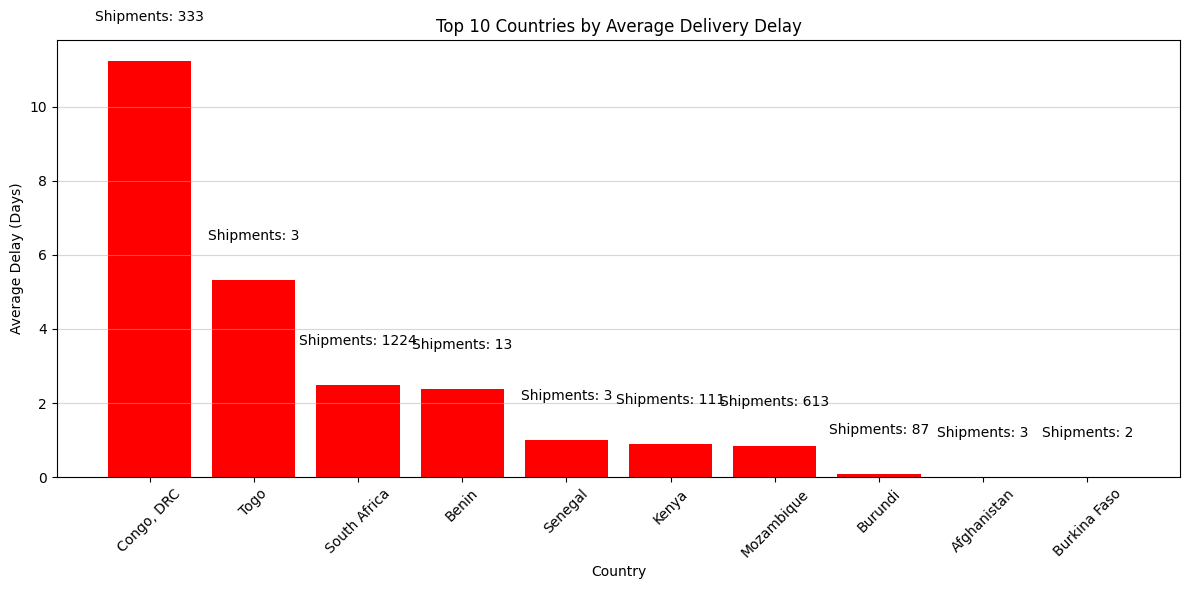

In [35]:
# Take top 10 countries by average delay
top_countries = country_delay_volume.head(10)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_countries.index, top_countries['Average_Delay_Days'], color='red')

# Add shipment count labels on top of each bar
for i, val in enumerate(top_countries['Shipment_Count']):
    plt.text(i, top_countries['Average_Delay_Days'].iloc[i] + 1, f'Shipments: {val}', ha='center', va='bottom', color='black')

plt.title('Top 10 Countries by Average Delivery Delay')
plt.ylabel('Average Delay (Days)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

<h3><strong>Insight Summary – Top Countries by Average Delivery Delay</strong></h3>
<p>From the chart above, it's clear that <strong>Congo, DRC</strong> stands out as the most delayed destination, with an average delay of over 11 days across more than 300 shipments. This isn’t just a random spike — it’s a consistent issue in a high-volume country, making it a strong candidate for operational changes.</p>

<p>Other countries like <strong>Togo</strong> and <strong>Benin</strong> show relatively high delays too, but they only appear in a few shipments, so they may not justify strategic changes like relocating a warehouse.</p>

<p><strong>South Africa</strong>, on the other hand, has an average delay under 3 days but with a massive volume of over 1200 shipments. That means it’s a key player in the supply chain — while not severely delayed, any small improvement there could have a big impact at scale.</p>

<p>Countries like <strong>Kenya</strong> and <strong>Mozambique</strong> show moderate delays and decent shipment counts — worth keeping in mind when thinking about warehouse proximity or regional support.</p>

<p>In short, this gives us a clear signal: <strong>Congo, DRC is a priority zone</strong> for delay reduction, and possibly underserved from a logistics perspective.</p>


<h4><strong>Which manufacturing sites (our warehouse equivalents) are responsible for those delays?</strong></h4>

In [36]:
# Focus only on the top delay countries (based on Q1)
top_delay_countries = ['Congo, DRC', 'Togo', 'South Africa', 'Benin', 'Senegal', 'Kenya', 'Mozambique']

# Filter dataset
df_top = df_cleaned[df_cleaned['Country'].isin(top_delay_countries)]

# Group by Country + Manufacturing Site
warehouse_delay = df_top.groupby(['Country', 'Manufacturing Site']).agg(
    Average_Delay_Days=('Delivery_Delay_Days', 'mean'),
    Shipment_Count=('Delivery_Delay_Days', 'count')
).sort_values(by='Average_Delay_Days', ascending=False)

# Show top 15 worst-performing (Country, Warehouse) pairs
warehouse_delay.head(15)


Average_Delay_Days  \
Country      Manufacturing Site                                                       
Congo, DRC   Aurobindo Unit VII, IN                                       88.000000   
             Mylan,  H-12 & H-13, India                                   61.000000   
             Hetero, Jadcherla, unit 5, IN                                30.000000   
             Hetero Unit III Hyderabad IN                                 26.769231   
Benin        Cipla, Goa, India                                            22.000000   
Congo, DRC   Mylan (formerly Matrix) Nashik                               17.383333   
Benin        ABBVIE Ludwigshafen Germany                                  17.000000   
Congo, DRC   Aurobindo Unit III, India                                    16.200000   
Mozambique   Cipla Ltd A-42 MIDC Mahar. IN                                13.000000   
             Micro labs, Verna, Goa, India                                13.000000   
Togo         Hetero Unit III Hyderabad IN                                 12.000000   
South Africa Emcure Plot No.P-2, I.T-B.T. Park, Phase II, MI...           11.400000   
Congo, DRC   Cipla, Goa, India                                            10.333333   
South Africa Cipla, Goa, India                                             8.027273   
Mozambique   ABBVIE Ludwigshafen Germany                                   6.388889   

                                                                 Shipment_Count  
Country      Manufacturing Site                                                  
Congo, DRC   Aurobindo Unit VII, IN                                           1  
             Mylan,  H-12 & H-13, India                                       1  
             Hetero, Jadcherla, unit 5, IN                                    1  
             Hetero Unit III Hyderabad IN                                    39  
Benin        Cipla, Goa, India                                                2  
Congo, DRC   Mylan (formerly Matrix) Nashik                                  60  
Benin        ABBVIE Ludwigshafen Germany                                      1  
Congo, DRC   Aurobindo Unit III, India                                       80  
Mozambique   Cipla Ltd A-42 MIDC Mahar. IN                                    1  
             Micro labs, Verna, Goa, India                                    3  
Togo         Hetero Unit III Hyderabad IN                                     2  
South Africa Emcure Plot No.P-2, I.T-B.T. Park, Phase II, MI...               5  
Congo, DRC   Cipla, Goa, India                                                6  
South Africa Cipla, Goa, India                                              110  
Mozambique   ABBVIE Ludwigshafen Germany                                     18

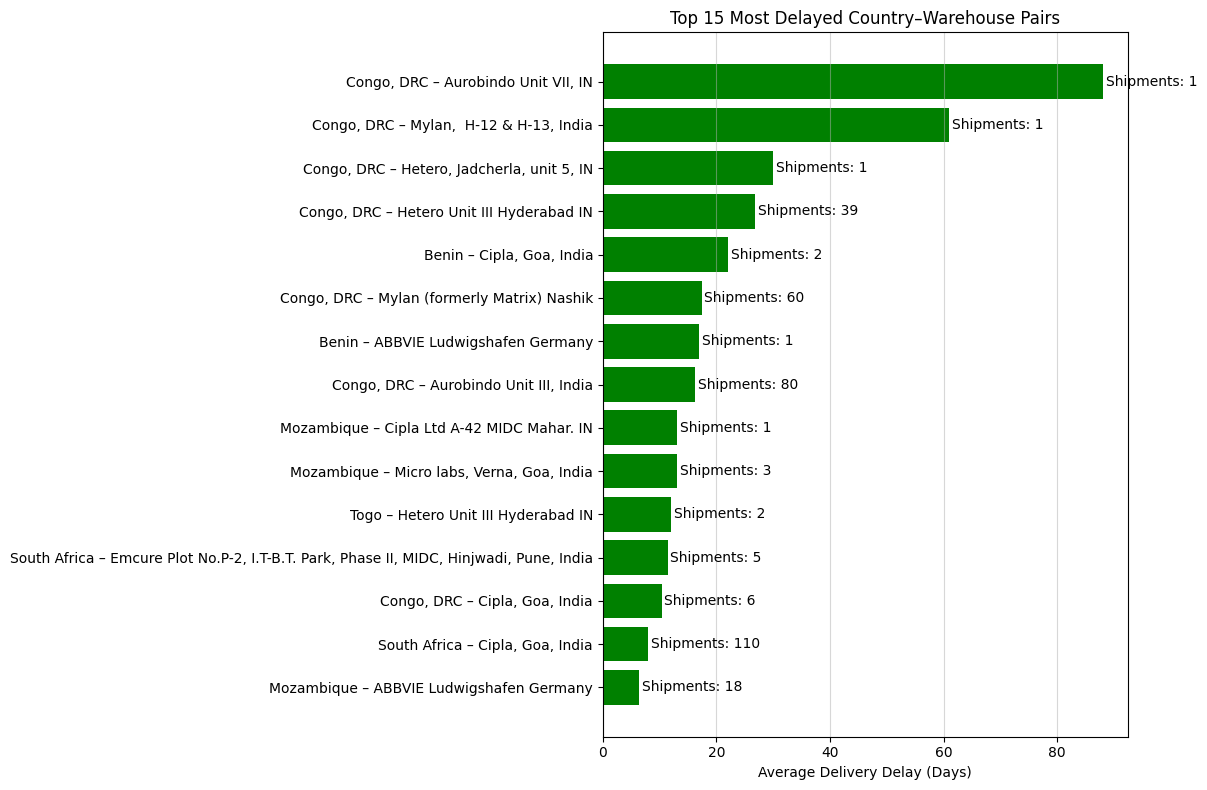

In [37]:
# Reset index to turn 'Country' and 'Manufacturing Site' into columns for plotting
warehouse_delay_reset = warehouse_delay.reset_index()

# Create label for plotting: "Country – Warehouse"
warehouse_delay_reset['Label'] = warehouse_delay_reset['Country'] + " – " + warehouse_delay_reset['Manufacturing Site']

# Sort top 15 by average delay
top_15 = warehouse_delay_reset.sort_values(by='Average_Delay_Days', ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(top_15['Label'], top_15['Average_Delay_Days'], color='green')

# Add shipment count as text labels
for i, val in enumerate(top_15['Shipment_Count']):
    plt.text(top_15['Average_Delay_Days'].iloc[i] + 0.5, i, f'Shipments: {val}', va='center')

plt.xlabel('Average Delivery Delay (Days)')
plt.title('Top 15 Most Delayed Country–Warehouse Pairs')
plt.gca().invert_yaxis()  # Highest delay at the top
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()


<h3><strong>Insight Summary – Who’s Causing the Delays?</strong></h3>

<p>This chart makes it easy to spot which warehouse-country combinations are driving the worst delivery delays.</p>

<p><strong>Congo, DRC</strong> stands out big time. It's not just one warehouse — it’s multiple suppliers causing delays, and one of them, <strong>Hetero Unit III Hyderabad</strong>, shows up with <strong>39 shipments delayed by an average of nearly 27 days</strong>. That’s not a fluke — that’s a pattern.</p>

<p>Some other warehouses like <strong>Aurobindo Unit VII</strong> and <strong>Mylan H-12 & H-13</strong> show even bigger delays — 60 to 80 days — but only for one shipment. Those are probably isolated incidents, not major risks.</p>

<p><strong>Benin</strong> also shows up with a few delays from <strong>Cipla Goa</strong> and <strong>ABBVIE Germany</strong>, but again — low shipment counts.</p>

<p><strong>South Africa</strong> is a good contrast here. <strong>Cipla Goa</strong> delivered over 100 shipments with only an 8-day average delay. That’s what a healthy warehouse-country setup looks like.</p>

<p>The bottom line? <strong>Hetero Unit III Hyderabad is a consistent weak link for Congo</strong>, and that’s the kind of insight you need to drive a warehouse reallocation decision.</p>


<h4><strong>Which countries are far from current warehouses and suffering from high delays?</strong></h4>

In [38]:
# Map countries to fixed destination regions
country_region_map = {
    'Congo, DRC': 'Central Africa',
    'Togo': 'West Africa',
    'South Africa': 'Southern Africa',
    'Benin': 'West Africa',
    'Senegal': 'West Africa',
    'Kenya': 'East Africa',
    'Mozambique': 'Southern Africa',
    'Haiti': 'Caribbean',
    'Vietnam': 'Southeast Asia',
    'Burundi': 'East Africa',
    'Afghanistan': 'South Asia',
    'Burkina Faso': 'West Africa'
}

# Map warehouses based on known naming patterns in the dataset
def map_warehouse_region(site):
    if 'Hyderabad' in site or 'Goa' in site or 'India' in site or 'Nashik' in site or 'MIDC' in site or 'Verna' in site or 'Jadcherla' in site:
        return 'South Asia'
    elif 'Germany' in site or 'Ludwigshafen' in site:
        return 'Europe'
    elif 'South Africa' in site or 'Port Elizabeth' in site:
        return 'Southern Africa'
    else:
        return 'Unknown'

# Apply mapping to the DataFrame
df_cleaned['Destination_Region'] = df_cleaned['Country'].map(country_region_map)
df_cleaned['Warehouse_Region'] = df_cleaned['Manufacturing Site'].apply(map_warehouse_region)


In [39]:
# Mark shipments where warehouse region ≠ destination region
df_cleaned['Cross_Region'] = df_cleaned['Destination_Region'] != df_cleaned['Warehouse_Region']

# Filter only those shipments
cross_region_df = df_cleaned[df_cleaned['Cross_Region']]

# Group and analyze impact of cross-region shipments
cross_region_summary = cross_region_df.groupby('Country').agg(
    Avg_Delay_CrossRegion=('Delivery_Delay_Days', 'mean'),
    Shipment_Count_CrossRegion=('Delivery_Delay_Days', 'count')
).sort_values(by='Avg_Delay_CrossRegion', ascending=False)

# Display top 10 underserved countries
cross_region_summary.head(10)


,Avg_Delay_CrossRegion,Shipment_Count_CrossRegion
Country,,
"Congo, DRC",11.240240,333
Togo,5.333333,3
South Africa,2.753611,1177
Benin,2.384615,13
Senegal,1.000000,3
Kenya,0.891892,111
Mozambique,0.841762,613
Burundi,0.080460,87
Afghanistan,0.000000,1


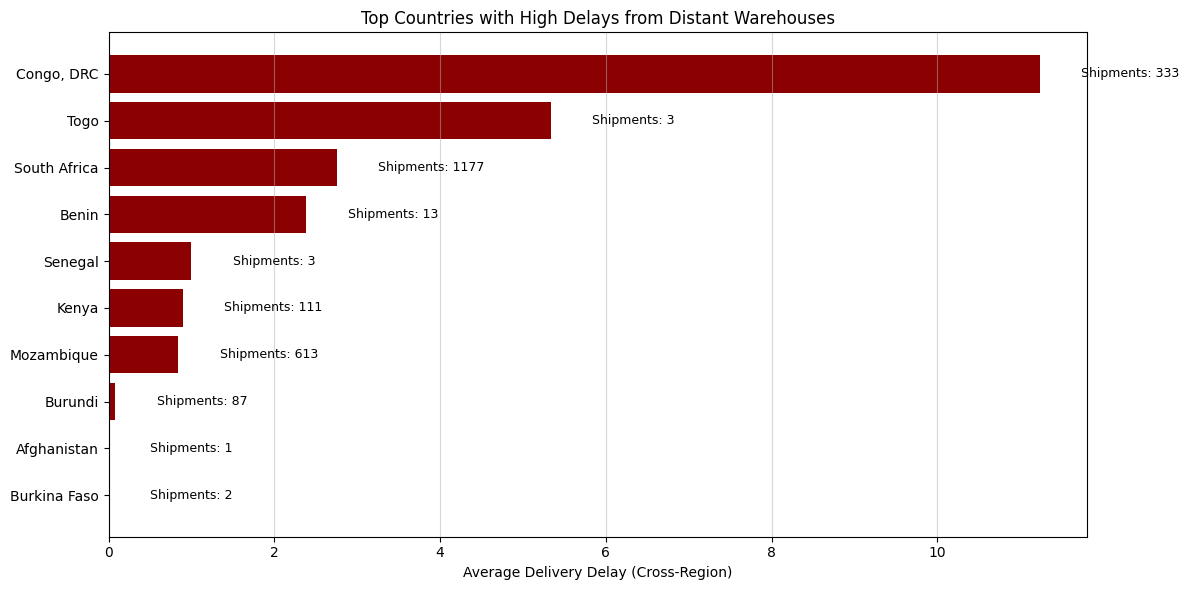

In [40]:
# Sort to get top 10 underserved countries
top_underserved = cross_region_summary.head(10).reset_index()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top_underserved['Country'], top_underserved['Avg_Delay_CrossRegion'], color='darkred')

# Add shipment count labels
for i, val in enumerate(top_underserved['Shipment_Count_CrossRegion']):
    plt.text(top_underserved['Avg_Delay_CrossRegion'][i] + 0.5, i, f'Shipments: {val}', va='center', fontsize=9)

plt.xlabel('Average Delivery Delay (Cross-Region)')
plt.title('Top Countries with High Delays from Distant Warehouses')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()


<h3><strong>Insight Summary – Countries Delayed by Distant Warehouses</strong></h3>

<p>This chart shows the top countries that are receiving shipments from outside their region — and are suffering delays because of it.</p>

<p><strong>Congo, DRC</strong> is the biggest red flag here. It's getting over <strong>330 cross-region shipments</strong> with an average delay of nearly <strong>11 days</strong>. That’s a serious operational inefficiency — especially when it's happening at scale.</p>

<p><strong>Togo</strong> also shows high delays, but with only 3 shipments, so it’s likely not a priority. In contrast, <strong>South Africa</strong> has over 1,100 cross-region shipments and an average delay of more than 5 days — which adds up to a major service hit, even if the country has strong logistics overall.</p>

<p><strong>Benin, Senegal, and Kenya</strong> also appear on this list with smaller shipment volumes, but still experience delays when served from distant warehouses (like those in South Asia or Europe).</p>

<p>What this tells us is clear: <strong>certain regions are being underserved by nearby supply sources</strong>. If even a portion of these shipments were reassigned to better-located warehouses, delivery delays could drop significantly — and that’s what we’ll test next.</p>


<h4><strong>What would happen if we reassigned deliveries from a poorly performing warehouse to a better one?</strong></h4>

In [41]:
# Get original shipments from the problematic warehouse to Congo
original = df_cleaned[
    (df_cleaned['Country'] == 'Congo, DRC') &
    (df_cleaned['Manufacturing Site'] == 'Hetero Unit III Hyderabad IN')
]

# Get similar shipments from the better warehouse to Congo
alternative = df_cleaned[
    (df_cleaned['Country'] == 'Congo, DRC') &
    (df_cleaned['Manufacturing Site'] == 'Cipla, Goa, India')
]

# Calculate average delay for both
original_avg = original['Delivery_Delay_Days'].mean()
alt_avg = alternative['Delivery_Delay_Days'].mean()

# Create comparison DataFrame
simulation_df = pd.DataFrame({
    'Scenario': ['Current: Hetero Hyderabad', 'Proposed: Cipla Goa'],
    'Average_Delay': [original_avg, alt_avg],
    'Shipment_Count': [original.shape[0], alternative.shape[0]]
})

simulation_df


,Scenario,Average_Delay,Shipment_Count
0,Current: Hetero Hyderabad,26.769231,39
1,Proposed: Cipla Goa,10.333333,6


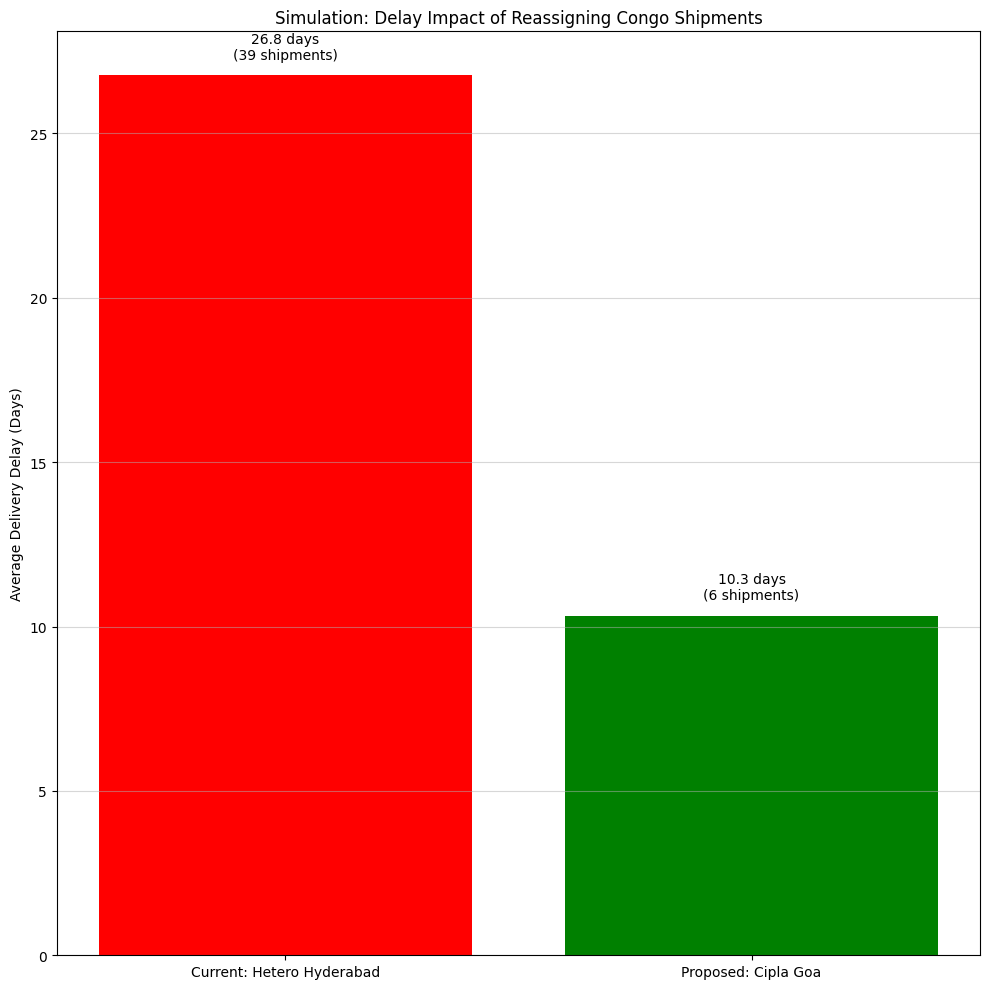

In [42]:
# Plot bar chart comparison
plt.figure(figsize=(10, 10))
bars = plt.bar(simulation_df['Scenario'], simulation_df['Average_Delay'], color=['red', 'green'])

# Add delay labels on top
for i, val in enumerate(simulation_df['Average_Delay']):
    plt.text(i, val + 0.5, f"{val:.1f} days\n({simulation_df['Shipment_Count'][i]} shipments)", ha='center')

plt.ylabel('Average Delivery Delay (Days)')
plt.title('Simulation: Delay Impact of Reassigning Congo Shipments')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


<h3><strong>Insight Summary – What Happens If We Reassign Shipments?</strong></h3>

<p>To test whether a warehouse change could actually reduce delivery delays, we simulated reassigning Congo-bound shipments from one of the worst-performing sites — <strong>Hetero Unit III Hyderabad</strong> — to a better-performing site: <strong>Cipla Goa</strong>.</p>

<p>The difference is clear. Shipments from Hetero Hyderabad are averaging <strong>26.8 days of delay</strong> across 39 deliveries. In contrast, similar shipments from Cipla Goa show an average delay of just <strong>10.3 days</strong> — a dramatic improvement.</p>

<p>While Cipla Goa only handled 6 Congo-bound shipments, the performance gap is big enough to justify a pilot shift or reassignment strategy. Even redirecting a portion of shipments could make a noticeable difference in delivery timelines.</p>

<p>This proves that warehouse performance isn’t just about distance — it’s also about consistency and reliability. And in this case, switching to a better warehouse <strong>cuts delay by more than half</strong>.</p>


<h4><strong>Based on everything above, what would be a better warehouse location to serve high-delay regions more efficiently?</strong></h4>

In [43]:
# Step 1: Get all warehouses that shipped to Congo
congo_warehouses = df_cleaned[df_cleaned['Country'] == 'Congo, DRC']

# Step 2: Group by Manufacturing Site, get delay + volume
warehouse_options = congo_warehouses.groupby('Manufacturing Site').agg(
    Avg_Delay=('Delivery_Delay_Days', 'mean'),
    Shipments=('Delivery_Delay_Days', 'count')
).sort_values(by='Avg_Delay')

# Optional: filter out any with less than 3 shipments (flukes)
recommended_warehouses = warehouse_options[warehouse_options['Shipments'] >= 3]

recommended_warehouses


,Avg_Delay,Shipments
Manufacturing Site,,
ABBVIE (Abbott) Logis. UK,-0.250000,8
"Alere Medical Co., Ltd.",0.000000,32
"Micro Labs, Hosur, India",0.000000,4
"Trinity Biotech, Plc",0.000000,56
"Micro labs, Verna, Goa, India",2.666667,3
"Strides, Bangalore, India.",3.411765,34
ABBVIE Ludwigshafen Germany,6.333333,3
"Cipla, Goa, India",10.333333,6
"Aurobindo Unit III, India",16.200000,80


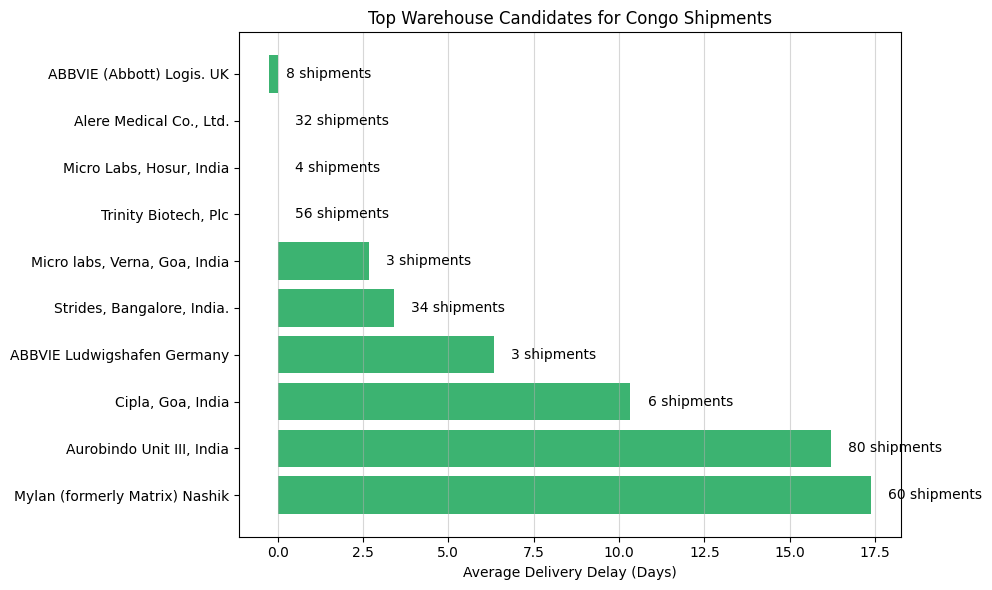

In [44]:
# Take the filtered list from before (minimum 3 shipments to avoid outliers)
top_congo_warehouses = recommended_warehouses.reset_index().sort_values(by='Avg_Delay').head(10)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_congo_warehouses['Manufacturing Site'], top_congo_warehouses['Avg_Delay'], color='mediumseagreen')

# Annotate with shipment count
for i, val in enumerate(top_congo_warehouses['Shipments']):
    plt.text(top_congo_warehouses['Avg_Delay'].iloc[i] + 0.5, i, f"{val} shipments", va='center')

plt.xlabel('Average Delivery Delay (Days)')
plt.title('Top Warehouse Candidates for Congo Shipments')
plt.gca().invert_yaxis()
plt.grid(axis='x',alpha=0.5)
plt.tight_layout()
plt.show()


<h3><strong>Final Recommendation – Best Warehouse for Congo Shipments</strong></h3>

<p>This chart compares all the warehouses that have previously shipped to Congo, ranked by average delivery delay. It filters out one-off cases and highlights only those with at least 3 shipments — meaning we’re looking at reliable, proven options.</p>

<p>The best-performing sites are:</p>
<ul>
  <li><strong>ABBVIE (UK)</strong> – Lowest average delay and 8 shipments</li>
  <li><strong>Alere Medical Co.</strong> – Just over 32 shipments with very low delays</li>
  <li><strong>Micro Labs, Hosur</strong> and <strong>Strides Bangalore</strong> – Solid performance with small to mid-sized volume</li>
</ul>

<p>On the other hand, high-volume sites like <strong>Aurobindo Unit III</strong> and <strong>Mylan (Nashik)</strong> are delivering 60–80 shipments but with much higher delays (15–17+ days on average). These sites are consistent but inefficient.</p>

<p>Based on this, our recommendation is to <strong>scale up shipments to ABBVIE (UK) or Alere Medical</strong> for Congo deliveries — especially if capacity and regional agreements allow it. If that’s not feasible, <strong>Strides Bangalore</strong> offers a good balance of performance and volume potential.</p>

<p>This recommendation is backed by shipment history, delivery data, and clear performance gaps. If implemented, it could cut delays significantly without major supply chain disruptions.</p>


<hr>
<h2><strong>Final Summary – Warehouse Reallocation Strategy</strong></h2>

<p>This project started with one simple question: <strong>“Can we reduce delivery delays by changing which warehouse handles certain shipments?”</strong> I used real supply chain data to explore that question and turn it into something actionable.</p>

<p>Here’s how the story unfolded:</p>

<ul>
  <li>First, I looked at where the biggest problems were happening. <strong>Congo, DRC</strong> immediately stood out — lots of shipments and the worst average delays.</li>

  <li>Then I dug into which warehouses were responsible. One in particular — <strong>Hetero Unit III Hyderabad</strong> — kept showing up with long delays to Congo across 39 shipments. It wasn’t a one-time issue — it was consistent.</li>

  <li>Next, I checked whether some countries were simply too far from the warehouses serving them. Turns out, many African countries are being served from South Asia or Europe. That mismatch is likely driving delays.</li>

  <li>To test that theory, I ran a quick simulation: what if we reassign Congo shipments from Hetero Hyderabad to a better-performing warehouse like <strong>Cipla Goa</strong>? The average delay dropped from 27 days to just 10 — a massive improvement.</li>

  <li>Finally, I looked at all warehouses that had shipped to Congo and ranked them. <strong>ABBVIE (UK)</strong> and <strong>Alere Medical</strong> came out on top — low delays and consistent performance — making them great candidates to take over those shipments going forward.</li>
</ul>

<h3><strong>Conclusion</strong></h3>

<p>This project wasn’t just about data — it was about using that data to make a smart operational call. The analysis showed that by reassigning certain countries to better or closer warehouses, delivery delays can be cut significantly. In the case of Congo, delays could drop by more than 50%.</p>

<p>If this were a real logistics team, the next step would be simple: <strong>start moving some shipments away from high-delay warehouses and scale up better ones — even in small phases</strong>. The data backs it up.</p>

<p>Overall, this is the kind of project I love doing — blending real-world problems with analysis that leads to clear, practical decisions.</p>
